In [8]:
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [9]:
df = pd.read_csv('all.csv')

In [14]:
df

,repetition,blksize,mode,benchmark,job,read_bw,write_bw
0,0,256k,randread,fio,randread-sdb-256k-seq,100,0
1,0,256k,read,fio,read-sdb-256k-seq,99,0
2,0,256k,write,fio,write-sdb-256k-seq,0,100
3,0,4096k,randread,fio,randread-sdb-4096k-seq,106,0
4,0,4096k,read,fio,read-sdb-4096k-seq,90,0
5,0,4096k,write,fio,write-sdb-4096k-seq,0,106
6,0,4k,randread,fio,randread-sdb-4k-seq,99,0
7,0,4k,read,fio,read-sdb-4k-seq,99,0
8,0,4k,write,fio,write-sdb-4k-seq,0,99
9,1,256k,randread,fio,randread-sdb-256k-seq,99,0


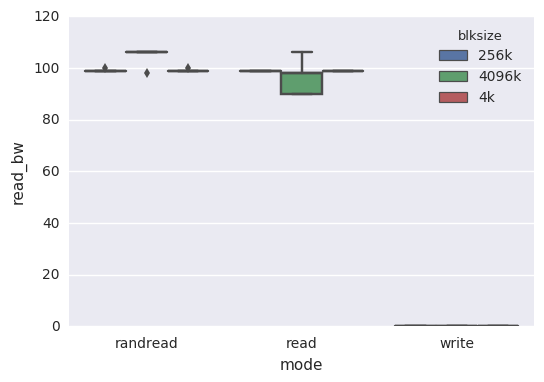

In [21]:
sns.boxplot(x='mode', y='read_bw', data=df, hue='blksize')

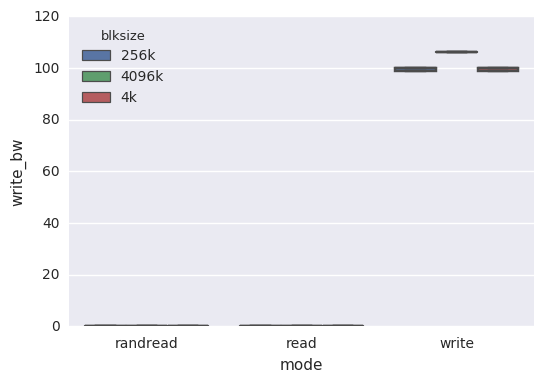

In [20]:
sns.boxplot(x='mode', y='write_bw', data=df, hue='blksize', showfliers=False)